In [1]:
# !pip install imblearn
# !pip install xgboost
# !pip install tensorflow
# !pip install imbalanced-learn

import pandas as pd
import joblib
import pickle as pkl
import re, os, pathlib
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost
from imblearn.over_sampling import SMOTE
from sklearn import metrics  
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import f1_score, recall_score, make_scorer
import metrics_plots
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [25]:
DataFrame = df = pd.read_csv('clean_dataframe_Seattle.csv')

C:\Users\Prudhvi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (12,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

In [26]:
DataFrame['Business_Zipcode'] = DataFrame['Business_Zipcode'].replace(to_replace ='WA', value =0)
DataFrame['Business_Zipcode'] = DataFrame['Business_Zipcode'].apply(lambda s: str(s).replace('"', ""))
DataFrame['Customer_Review_Uploaded_Photos'] = DataFrame['Customer_Review_Uploaded_Photos'].replace(to_replace =['First','ROTD','Purchased','Booked'], value =-1)
DataFrame['Customer_Review_Uploaded_Photos'] = pd.to_numeric(DataFrame['Customer_Review_Uploaded_Photos'])
DataFrame['Customer_Gender'] = DataFrame['Customer_Gender'].apply(lambda s: str(s).replace('mostly_female', "female"))
DataFrame['Customer_Gender'] = DataFrame['Customer_Gender'].apply(lambda s: str(s).replace('mostly_male', "male"))
DataFrame.fillna(0, inplace=True)

In [27]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97584 entries, 0 to 97583
Data columns (total 35 columns):
Unnamed: 0                         97584 non-null int64
Business_Name                      97584 non-null object
Business_ReviewCount               97584 non-null int64
Business_Rating                    97584 non-null float64
Business_Claim_status              97584 non-null int64
Customer_Friends_count             97584 non-null int64
Customer_Reviews_count             97584 non-null int64
Customer_Photos_count              97584 non-null int64
Customer_Elite                     97584 non-null object
Customer_Rating                    97584 non-null int64
Customer_Review                    97584 non-null object
Customer_Review_Date               97584 non-null object
Customer_Review_Uploaded_Photos    97584 non-null int64
Customer_Review_Useful             97584 non-null int64
Customer_Review_Funny              97584 non-null int64
Customer_Review_Cool               97584 non-

# Feature Engineering

In [28]:
# function to normalize the features
def Normalize_Function(df, column_list):
    # apply standardization on numerical features
    for column in column_list:
        # fit on training data column
        scale = MinMaxScaler().fit(df[[column]])    
        # transform the training data column
        df[column] = scale.transform(df[[column]])
    
    return df

# label encoder 
def label_encoder(DataFrame, column_list):  
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column  
    for column in column_list:
        DataFrame[column]= label_encoder.fit_transform(DataFrame[column]) 
    return DataFrame

In [29]:
# columns required to scale
columns_to_scale = ['Customer_Friends_count','Customer_Reviews_count', 'Customer_Photos_count','Customer_Review_Useful',
                   'Customer_Review_Funny', 'Customer_Review_Cool']

# calling the  Normalize_Function to scale the features
DataFrame = Normalize_Function(DataFrame, columns_to_scale)


# label encoding
columns_to_encode = ['Business_Name', 'Customer_Elite', 'Business_State', 'Business_Zipcode',
                     'Business_City', 'Customer_Gender',  'Sentiment_Score','Category']


DataFrame = label_encoder(DataFrame,columns_to_encode)

In [30]:
DataFrame.drop('Customer_Review', axis=1, inplace=True)
DataFrame.drop('Customer_Review_Date', axis=1, inplace=True)
DataFrame.drop('Cleaned_Customer_Review', axis=1, inplace=True)
DataFrame.drop('Business_Name', axis=1, inplace=True)
DataFrame.drop('Business_State', axis=1, inplace=True)
DataFrame.drop('Customer_Review_Uploaded_Photos', axis=1, inplace=True)
DataFrame.drop('Unnamed: 0', axis=1, inplace=True)
DataFrame.head()

,Business_ReviewCount,Business_Rating,Business_Claim_status,Customer_Friends_count,Customer_Reviews_count,Customer_Photos_count,Customer_Elite,Customer_Rating,Customer_Review_Useful,Customer_Review_Funny,...,Customer_Review_Day,review_word_count,review_char_count,review_avg_word_length,review_sentence_count,review_avg_sentence_length,polarity,subjectivity,Sentiment_Score,Business_Operational_Hours
0,1,5.0,0,0.000000,0.000233,0.000000,0,5,0.000000,0.0,...,0,44,250,4.704545,4,11.000000,0.483333,0.309524,2,0.0
1,31,4.0,1,0.002603,0.000155,0.000000,0,5,0.000000,0.0,...,0,49,273,4.591837,3,16.333333,0.092593,0.482407,2,11.0
2,31,4.0,1,0.001402,0.008085,0.000061,0,5,0.000000,0.0,...,4,104,591,4.605769,4,26.000000,0.403846,0.656838,2,11.0
3,31,4.0,1,0.074690,0.018812,0.007392,1,4,0.000000,0.0,...,2,74,421,4.702703,5,14.800000,-0.098333,0.458333,0,11.0
4,31,4.0,1,0.000000,0.000622,0.000000,0,1,0.041667,0.0,...,6,378,2047,4.415344,21,18.000000,0.003324,0.381061,2,11.0


In [31]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97584 entries, 0 to 97583
Data columns (total 28 columns):
Business_ReviewCount          97584 non-null int64
Business_Rating               97584 non-null float64
Business_Claim_status         97584 non-null int64
Customer_Friends_count        97584 non-null float64
Customer_Reviews_count        97584 non-null float64
Customer_Photos_count         97584 non-null float64
Customer_Elite                97584 non-null int32
Customer_Rating               97584 non-null int64
Customer_Review_Useful        97584 non-null float64
Customer_Review_Funny         97584 non-null float64
Customer_Review_Cool          97584 non-null float64
Business_Response             97584 non-null int64
Category                      97584 non-null int32
Business_Zipcode              97584 non-null int32
Business_City                 97584 non-null int32
Business_Timings_From         97584 non-null int64
Business_Timings_To           97584 non-null int64
Customer_G

In [32]:
# DataFrame["Business_Name"] = DataFrame["Business_Name"].astype("category")
DataFrame["Business_Rating"] = DataFrame["Business_Rating"].astype("category")
DataFrame["Business_Claim_status"] = DataFrame["Business_Claim_status"].astype("category")
DataFrame["Customer_Elite"] = DataFrame["Customer_Elite"].astype("category")
DataFrame["Customer_Rating"] = DataFrame["Customer_Rating"].astype("category")
DataFrame["Category"] = DataFrame["Category"].astype("category")
DataFrame["Business_Zipcode"] = DataFrame["Business_Zipcode"].astype("category")
DataFrame["Business_City"] = DataFrame["Business_City"].astype("category")
DataFrame["Customer_Gender"] = DataFrame["Customer_Gender"].astype("category")
DataFrame["Sentiment_Score"] = DataFrame["Sentiment_Score"].astype("category")
DataFrame["Business_Response"] = DataFrame["Business_Response"].astype("category")
DataFrame["Customer_Review_Day"] = DataFrame["Customer_Review_Day"].astype("category")

In [33]:
# DataFrame = pd.get_dummies(DataFrame, columns=['Business_Rating',
#                                                'Business_Claim_status',
#                                                'Customer_Elite',
#                                                'Customer_Rating',
#                                                'Category',
#                                                'Business_Zipcode',
#                                                'Business_City',
#                                                'Customer_Gender',
#                                                'Sentiment_Score',
#                                                'Customer_Review_Day'])

In [34]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97584 entries, 0 to 97583
Data columns (total 28 columns):
Business_ReviewCount          97584 non-null int64
Business_Rating               97584 non-null category
Business_Claim_status         97584 non-null category
Customer_Friends_count        97584 non-null float64
Customer_Reviews_count        97584 non-null float64
Customer_Photos_count         97584 non-null float64
Customer_Elite                97584 non-null category
Customer_Rating               97584 non-null category
Customer_Review_Useful        97584 non-null float64
Customer_Review_Funny         97584 non-null float64
Customer_Review_Cool          97584 non-null float64
Business_Response             97584 non-null category
Category                      97584 non-null category
Business_Zipcode              97584 non-null category
Business_City                 97584 non-null category
Business_Timings_From         97584 non-null int64
Business_Timings_To           97584 non

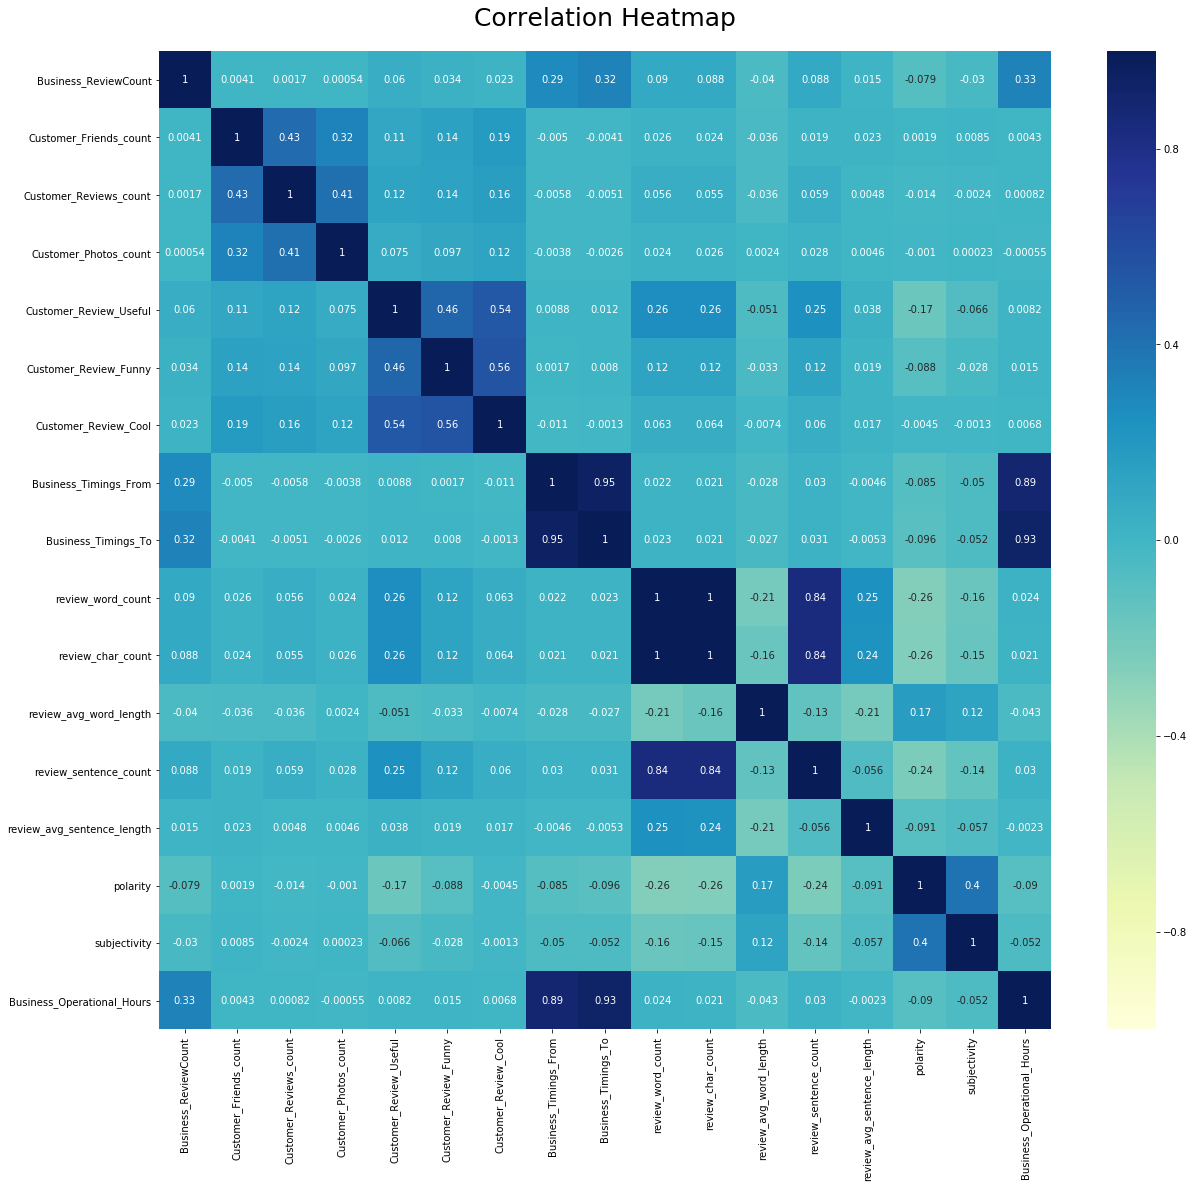

In [35]:
plt.figure(figsize=(20, 18))
heatmap = sns.heatmap(DataFrame.corr(), vmin=-1, vmax=1, annot=True, cmap= 'YlGnBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':25}, pad=25);

In [36]:

DataFrame = DataFrame.drop(columns=['review_char_count'], axis=0)
DataFrame = DataFrame.drop(columns=['review_word_count'], axis=0)
DataFrame = DataFrame.drop(columns=['subjectivity'], axis=0)


# Modeling

In [37]:
# splitting the data frame into Features and Target varibale for Testing  and Training the model 
X = DataFrame.drop(columns=['Business_Response'], axis=0)
y = DataFrame['Business_Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify= y)
print(DataFrame.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

X_test_final = X_test.copy()
y_test_final = y_test.copy()

(97584, 25)
(78067, 24)
(19517, 24)
0    63824
1    14243
Name: Business_Response, dtype: int64
0    15956
1     3561
Name: Business_Response, dtype: int64


In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97584 entries, 0 to 97583
Data columns (total 24 columns):
Business_ReviewCount          97584 non-null int64
Business_Rating               97584 non-null category
Business_Claim_status         97584 non-null category
Customer_Friends_count        97584 non-null float64
Customer_Reviews_count        97584 non-null float64
Customer_Photos_count         97584 non-null float64
Customer_Elite                97584 non-null category
Customer_Rating               97584 non-null category
Customer_Review_Useful        97584 non-null float64
Customer_Review_Funny         97584 non-null float64
Customer_Review_Cool          97584 non-null float64
Category                      97584 non-null category
Business_Zipcode              97584 non-null category
Business_City                 97584 non-null category
Business_Timings_From         97584 non-null int64
Business_Timings_To           97584 non-null int64
Customer_Gender               97584 non-nu

In [39]:
def confusion_matrix(y_test, y_pred):
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10,7))
    plt.title("confusion Matrix")
    sns.heatmap(cf_matrix, annot=True,fmt='d')
    return 0

f1 = make_scorer(f1_score )
recall_scorer = make_scorer(recall_score)



In [40]:
#Function to plot the ROC and PRC Curves
def AUC_PRC_Curves(targets, scores, label):
       # Compute ROC
        fpr, tpr, thresholds = roc_curve(targets, scores)
        auc_roc = auc(fpr, tpr)

        # Compute precision-recall AUC
        precision, recall, thresholds_prc = precision_recall_curve(targets, scores)
        auc_prc = auc(recall, precision)
        f1_scores = 2*(precision[:-1]*recall[:-1])/(precision[:-1]+recall[:-1])
        
        roc_results = {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds, 'auc':auc_roc}
        prc_results = {'precision':precision, 'recall':recall,
                   'thresholds':thresholds_prc, 'auc':auc_prc}
        
        
        # plot the no skill precision-recall curve
        no_skill = len(targets[targets==1]) / len(targets)
        
        
        
        fig, ax = plt.subplots(1, 3, figsize=(15,15))
        
        ax[0].plot(fpr, tpr, color='b')
        ax[0].plot([0,1], [0,1], 'r--')
        ax[0].set(xlabel='FPR', ylabel='TPR')
        ax[0].set_aspect('equal', 'box')
        ax[0].set_title('{0} AUC Curve'.format(label), fontweight ="bold")
        auc_text = ax[0].text(.05, .95, "AUC = %.4f" % auc_roc, 
                              color="k", fontsize=20)
        #print("ROC AUC:", auc_roc)

        # Generate precision-recall Curve plot
        ax[1].plot(recall, precision, color='b')
        ax[1].plot([0, 0, 1], [1, no_skill, no_skill], 'r--',label='No Skill')
#         ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        
        ax[1].set(xlabel='Recall', ylabel='Precision')
        ax[1].set_aspect('equal', 'box')
 
        auc_prc_text = ax[1].text(.2, .95, "PR AUC = %.4f" % auc_prc, 
                                color="k", fontsize=20)
        ax[1].set_title('{0} PR AUC Curve'.format(label), fontweight ="bold")

        # F1 vs Threshold plot
        ax[2].plot(thresholds_prc,f1_scores,color='b')
        ax[2].set(xlabel='Threshold', ylabel='F1 score')
        ax[2].set_aspect('equal', 'box')
        data = pd.DataFrame({'Thresholds':thresholds_prc,'f1_score':f1_scores})
        Threshold_cutoff = data.loc[data['f1_score'] == data.f1_score.max(),'Thresholds'].iloc[0]
        Max_F1score = data.f1_score.max()
        ax[2].set_title('{0} F1 vs Threshold Curve'.format(label), fontweight ="bold")
        ax[2].text(.2, .2, "Threshold_cutoff = %.4f" % Threshold_cutoff, color="k", fontsize=12)
        ax[2].text(.2, .1, "Max_F1score = %.4f" % Max_F1score, color="k", fontsize=12)
        
        return 0

## Random Forest Classifier

In [18]:
# define the model , 
model = RandomForestClassifier( bootstrap = True,
                               max_depth = 50, 
                               max_features = 'auto',
                               min_samples_leaf= 2,
                               min_samples_split= 10,
                               n_estimators= 500)
# fit the model on the whole dataset
model.fit(X_train, y_train)
#performing predictions on the test dataset
y_pred = model.predict(X_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8582261618076549
[[15431   525]
 [ 2242  1319]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     15956
           1       0.72      0.37      0.49      3561

    accuracy                           0.86     19517
   macro avg       0.79      0.67      0.70     19517
weighted avg       0.84      0.86      0.84     19517



In [19]:
#performing predictions on the test dataset
y_pred = model.predict(X_train)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

ACCURACY OF THE MODEL:  0.9443939180447565
[[63415   409]
 [ 3932 10311]]


### Random Forest Parameters Tuning with GridsearchCV

In [41]:
filename = 'RandomForest_GridSearch_recall.pkl'

model_params = { 'max_depth': [10,20,30,50],
                 'max_features':['auto'],
                 'min_samples_leaf': [3,5,10],
                 'min_samples_split': [2,5,8],
                 'n_estimators': [10,50,100]
                }

if not os.path.exists(filename):
    #intialize the model
    rf_model = RandomForestClassifier()
    # perform Grid search with params
    RandomForest_GridSearch = GridSearchCV(rf_model, model_params, cv = 5, verbose = 1, n_jobs = -1, scoring=f1)
    # get the best model with high f1 score
    RandomForest_Best_Model = RandomForest_GridSearch.fit(X_train, y_train)
    # save grid search object
    joblib.dump(RandomForest_GridSearch,'RandomForest_GridSearch_recall.pkl')
else:
    RandomForest_GridSearch = joblib.load('RandomForest_GridSearch_recall.pkl')

    


#### Results 

In [42]:
print("Best params: ", RandomForest_GridSearch.best_params_)
rf_best_model= RandomForest_GridSearch.best_estimator_
rf_best_model.fit(X_train,y_train)
rf_pred_test = rf_best_model.predict(X_test)

Best params:  {'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}


In [43]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, rf_pred_test))
print(metrics.confusion_matrix(y_test, rf_pred_test))
print(classification_report(y_test, rf_pred_test))

ACCURACY OF THE MODEL:  0.8561766664958754
[[15438   518]
 [ 2289  1272]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     15956
           1       0.71      0.36      0.48      3561

    accuracy                           0.86     19517
   macro avg       0.79      0.66      0.70     19517
weighted avg       0.84      0.86      0.84     19517



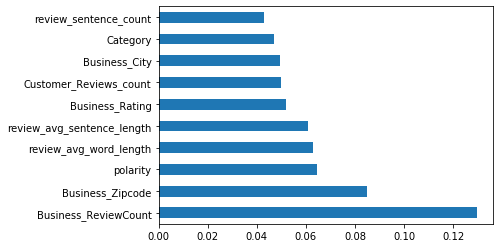

In [44]:
feat_importances = pd.Series(rf_best_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

0

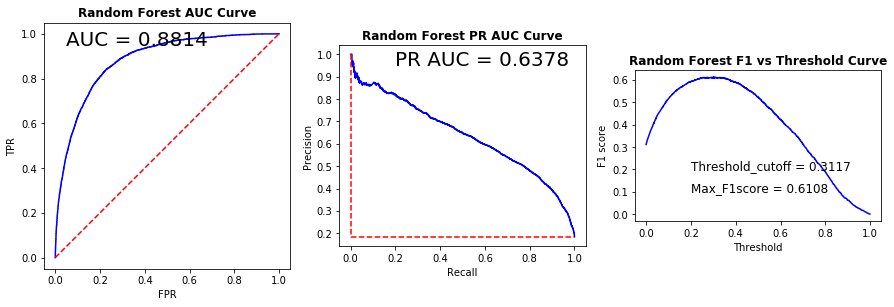

In [24]:
y_pred=rf_best_model.predict_proba(X_test)
AUC_PRC_Curves(y_test,y_pred[:,1],'Random Forest')

In [186]:
#performing predictions on the test dataset
y_pred = rf_best_model.predict(X_train)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

ACCURACY OF THE MODEL:  0.9832963992468008
[[63731    93]
 [ 1211 13032]]


# Gradient Boost Classifier

In [257]:
# from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier( n_estimators = 20, min_samples_split =50, min_samples_leaf = 10,
                                    max_depth = 20,
                                    learning_rate =1,
                                  random_state = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8313265358405493
[[14679  1277]
 [ 2015  1546]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15956
           1       0.55      0.43      0.48      3561

    accuracy                           0.83     19517
   macro avg       0.71      0.68      0.69     19517
weighted avg       0.82      0.83      0.82     19517



In [258]:
#performing predictions on the test dataset
y_pred = model.predict(X_train)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

ACCURACY OF THE MODEL:  1.0
[[63824     0]
 [    0 14243]]


# Tuning Gradient Boost 

In [259]:
filename = 'GradientBoost_GridSearch.pkl'

model_params = { 'max_depth': [8,16,24,32],
                 'learning_rate': [0.5,1,1.5],
                 'min_samples_split' : [100,300,500,700],
                 'n_estimators': [5,10, 25,50]
                }

if not os.path.exists(filename):
    #intialize the model
    gb_model = GradientBoostingClassifier()
    # perform Grid search with params
    GradientBoost_GridSearch = GridSearchCV(gb_model, model_params, cv = 3, verbose = 1, n_jobs = -1, scoring= f1)
    # get the best model with high f1 score
    GradientBoost_Best_Model = GradientBoost_GridSearch.fit(X_train, y_train)
    # save grid search object
    joblib.dump(GradientBoost_GridSearch,'GradientBoost_GridSearch.pkl')
else:
    GradientBoost_GridSearch = joblib.load('GradientBoost_GridSearch.pkl')

    


#### Results

In [260]:
print("Best params: ",GradientBoost_GridSearch.best_params_)
gb_best_model= GradientBoost_GridSearch.best_estimator_
gb_best_model.fit(X_train,y_train)
gb_pred_test = gb_best_model.predict(X_test)

Best params:  {'learning_rate': 0.5, 'max_depth': 20, 'n_estimators': 25}


In [261]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, gb_pred_test))
print(metrics.confusion_matrix(y_test, gb_pred_test))

print(classification_report(y_test, gb_pred_test))

ACCURACY OF THE MODEL:  0.8489521955218527
[[15106   850]
 [ 2098  1463]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     15956
           1       0.63      0.41      0.50      3561

    accuracy                           0.85     19517
   macro avg       0.76      0.68      0.70     19517
weighted avg       0.83      0.85      0.84     19517



In [262]:
#performing predictions on the test dataset
y_pred = gb_best_model.predict(X_train)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

ACCURACY OF THE MODEL:  1.0
[[63824     0]
 [    0 14243]]


0

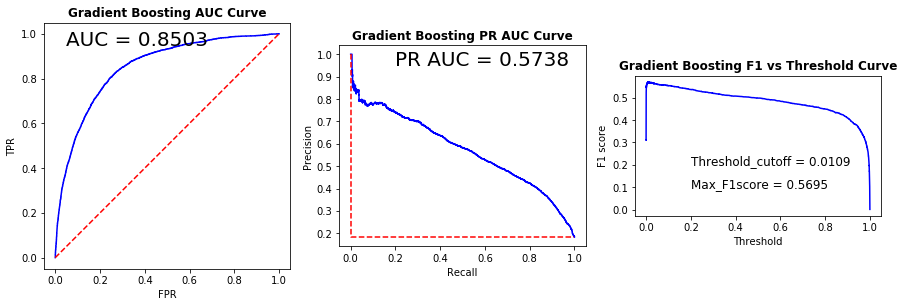

In [263]:
y_pred = gb_best_model.predict_proba(X_test)
AUC_PRC_Curves(y_test,y_pred[:,1],'Gradient Boosting')

## XGBoost Classifier

In [238]:
# fit model no training data
model = XGBClassifier(  scale_pos_weight =3,
                        max_depth=10,
                        reg_lambda=1.5,
                        learning_rate=0.3,
                        gamma = 0)

model.fit(X_train, y_train)


C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [239]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# 
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(metrics.confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Accuracy: 82.93%
[[13941  2015]
 [ 1317  2244]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     15956
           1       0.53      0.63      0.57      3561

    accuracy                           0.83     19517
   macro avg       0.72      0.75      0.73     19517
weighted avg       0.84      0.83      0.83     19517



C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0

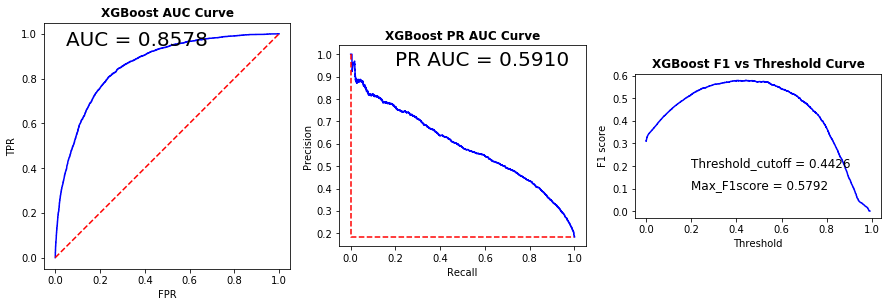

In [240]:
y_pred = model.predict_proba(X_test)
AUC_PRC_Curves(y_test,y_pred[:,1],'XGBoost')

In [237]:
# performing predictions on the test dataset
y_pred = model.predict(X_train)

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))
print(metrics.confusion_matrix(y_train, y_pred))

C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ACCURACY OF THE MODEL:  0.9201327065213214
[[58133  5691]
 [  544 13699]]


### Hyperparameter tuning of XGBoost

In [42]:
filename = 'XGBoost_GridSearch_new2_f1.pkl'

model_params = {"scale_pos_weight":[1, 3, 5],
                "max_depth":[3,4,6],
                "reg_lambda":[0, 1, 10],
                "learning_rate":[0.01,0.05,0.1],
                "gamma" : [0,0.5,1]
              }

# model_params = {"scale_pos_weight":[3,5,8],
#                 "max_depth":[6,8,10,12],
#                 "reg_lambda":[0, 1, 10,20],
#                 "learning_rate":[0.1,0.5,1],
#                 "gamma" : [1,2]
#               }

if not os.path.exists(filename):
    #intialize the model
    XGBoost_model = XGBClassifier(objective= 'binary:logistic',seed =42, subsample= 0.5, colsample_bytree=0.5)
    # perform Grid search with params
    XGBoost_GridSearch = GridSearchCV(XGBoost_model, model_params, cv = 5, verbose = 1, n_jobs = -1, scoring= 'accuracy')
    # get the best model with high f1 score
    XGBoost_Best_Model = XGBoost_GridSearch.fit(X_train, y_train)
    # save grid search object
    joblib.dump(XGBoost_GridSearch,'XGBoost_GridSearch_new2_f1.pkl')
else:
    XGBoost_GridSearch = joblib.load('XGBoost_GridSearch_new2_f1.pkl')

    


In [43]:
print("Best params: ",XGBoost_GridSearch.best_params_)
XGBoost_best_model= XGBoost_GridSearch.best_estimator_
XGBoost_best_model.fit(X_train,y_train)
XG_pred_test = XGBoost_best_model.predict(X_test)

Best params:  {'gamma': 2, 'learning_rate': 0.1, 'max_depth': 12, 'reg_lambda': 1, 'scale_pos_weight': 5}


C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [44]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, XG_pred_test))
print(metrics.confusion_matrix(y_test, XG_pred_test))
print(classification_report(y_test, XG_pred_test))

ACCURACY OF THE MODEL:  0.7973561510478044
[[12973  2983]
 [  972  2589]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     15956
           1       0.46      0.73      0.57      3561

    accuracy                           0.80     19517
   macro avg       0.70      0.77      0.72     19517
weighted avg       0.85      0.80      0.81     19517



C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0

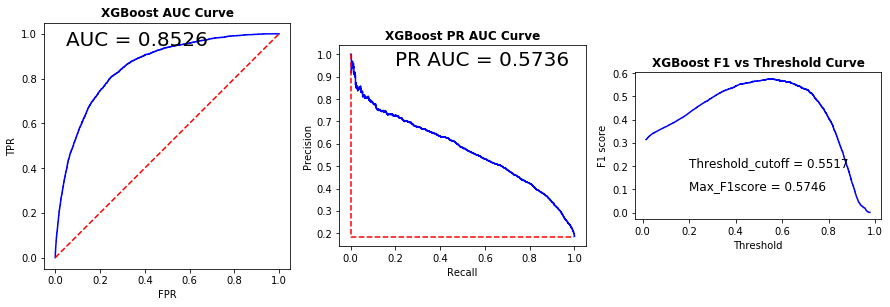

In [45]:
y_pred = XGBoost_best_model.predict_proba(X_test)
AUC_PRC_Curves(y_test,y_pred[:,1],'XGBoost')

In [324]:
XG_pred_train = XGBoost_best_model.predict(X_train)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, XG_pred_train))
print(metrics.confusion_matrix(y_train, XG_pred_train))

C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ACCURACY OF THE MODEL:  0.8767340873864757
[[54989  8835]
 [  788 13455]]


## SMOTE for Oversampling

In [213]:
X = DataFrame.drop(columns=['Business_Response'], axis=0)
y = DataFrame['Business_Response']

In [214]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts()

1    79780
0    79780
Name: Business_Response, dtype: int64

In [215]:
X_smote.head()

,Business_ReviewCount,Customer_Friends_count,Customer_Reviews_count,Customer_Photos_count,Customer_Review_Useful,Customer_Review_Funny,Customer_Review_Cool,Business_Timings_From,Business_Timings_To,review_word_count,...,Sentiment_Score_Negative,Sentiment_Score_Neutral,Sentiment_Score_Positive,Customer_Review_Day_0,Customer_Review_Day_1,Customer_Review_Day_2,Customer_Review_Day_3,Customer_Review_Day_4,Customer_Review_Day_5,Customer_Review_Day_6
0,1,0.000000,0.000233,0.000000,0.000000,0.0,0.0,0,0,44,...,0,0,1,1,0,0,0,0,0,0
1,31,0.002603,0.000155,0.000000,0.000000,0.0,0.0,7,6,49,...,0,0,1,1,0,0,0,0,0,0
2,31,0.001402,0.008085,0.000061,0.000000,0.0,0.0,7,6,104,...,0,0,1,0,0,0,0,1,0,0
3,31,0.074690,0.018812,0.007392,0.000000,0.0,0.0,7,6,74,...,1,0,0,0,0,1,0,0,0,0
4,31,0.000000,0.000622,0.000000,0.041667,0.0,0.0,7,6,378,...,0,0,1,0,0,0,0,0,0,1


In [216]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=42, stratify= y_smote)
print(DataFrame.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(97584, 375)
(78067, 374)
(19517, 374)
0    63824
1    14243
Name: Business_Response, dtype: int64
0    15956
1     3561
Name: Business_Response, dtype: int64


### Random Forest on Oversample data

In [224]:
rf_smote_model = RandomForestClassifier()
rf_smote_model.fit(X_smote_train, y_smote_train)
y_pred = rf_smote_model.predict(X_smote_test)

In [225]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_smote_test, y_pred))
print(metrics.confusion_matrix(y_smote_test, y_pred))
print(classification_report(y_smote_test, y_pred))

ACCURACY OF THE MODEL:  0.9054587615943845
[[15526   430]
 [ 2587 13369]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     15956
           1       0.97      0.84      0.90     15956

    accuracy                           0.91     31912
   macro avg       0.91      0.91      0.91     31912
weighted avg       0.91      0.91      0.91     31912



0

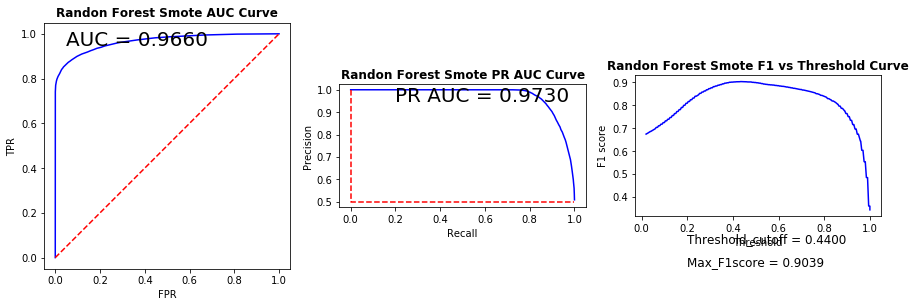

In [227]:
y_rf_pred = rf_smote_model.predict_proba(X_smote_test)
AUC_PRC_Curves(y_smote_test,y_rf_pred[:,1],'Randon Forest Smote')

### Gradient Boost on Oversample Data

In [221]:
gb_smote_model = GradientBoostingClassifier()
gb_smote_model.fit(X_smote_train, y_smote_train)
y_pred = gb_smote_model.predict(X_smote_test)

In [222]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_smote_test, y_pred))
print(metrics.confusion_matrix(y_smote_test, y_pred))
print(classification_report(y_smote_test, y_pred))

ACCURACY OF THE MODEL:  0.8838368012033091
[[15735   221]
 [ 3486 12470]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.89     15956
           1       0.98      0.78      0.87     15956

    accuracy                           0.88     31912
   macro avg       0.90      0.88      0.88     31912
weighted avg       0.90      0.88      0.88     31912



0

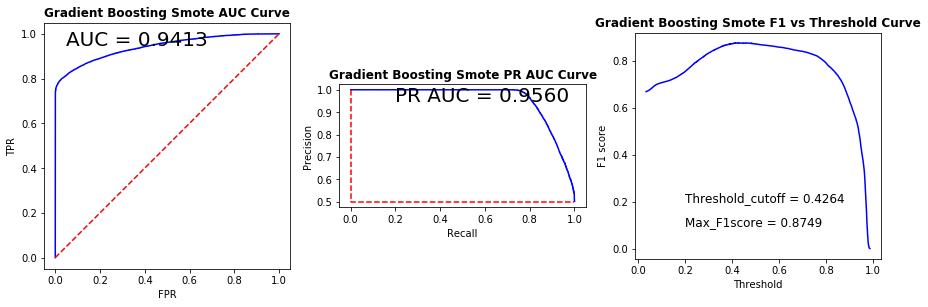

In [223]:
y_pred_gb_smote = gb_smote_model.predict_proba(X_smote_test)
AUC_PRC_Curves(y_smote_test,y_pred_gb_smote[:,1],'Gradient Boosting Smote')

### XGBoost on Oversample Data

In [217]:
xgb_smote_model = XGBClassifier()
xgb_smote_model.fit(X_smote_train, y_smote_train)
y_XG_pred = xgb_smote_model.predict(X_smote_test)

C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Prudhvi\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [218]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_smote_test, y_XG_pred))
print(metrics.confusion_matrix(y_smote_test, y_XG_pred))
print(classification_report(y_smote_test, y_XG_pred))

ACCURACY OF THE MODEL:  0.905897468037102
[[15298   658]
 [ 2345 13611]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     15956
           1       0.95      0.85      0.90     15956

    accuracy                           0.91     31912
   macro avg       0.91      0.91      0.91     31912
weighted avg       0.91      0.91      0.91     31912



0

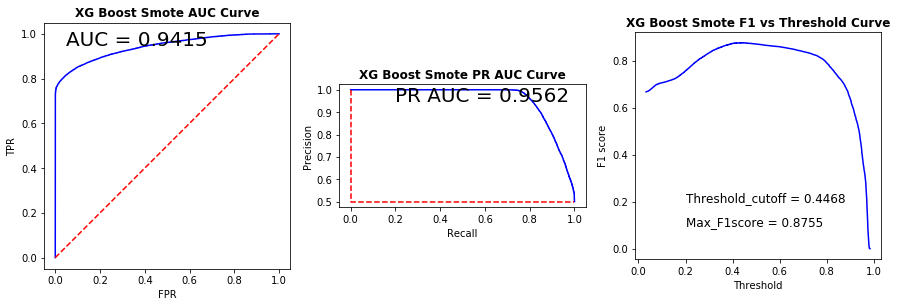

In [220]:
y_pred_XG_smote = gb_smote_model.predict_proba(X_smote_test)
AUC_PRC_Curves(y_smote_test,y_pred_XG_smote[:,1],'XG Boost Smote')

# Neural Networks

In [43]:
import tensorflow as tf
from tensorflow import keras

In [44]:
len(X_train.columns)

374

In [52]:
model = keras.Sequential([
    keras.layers.Dense(200, input_shape=(374,), activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2440/2440 [==============================] - 4s 1ms/step - loss: 0.5058 - accuracy: 0.8179
Epoch 2/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4449 - accuracy: 0.8166
Epoch 3/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4267 - accuracy: 0.8202
Epoch 4/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4255 - accuracy: 0.8161
Epoch 5/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4216 - accuracy: 0.8147
Epoch 6/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4160 - accuracy: 0.8186
Epoch 7/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4074 - accuracy: 0.8190
Epoch 8/100
2440/2440 [==============================] - 3s 1ms/step - loss: 0.4110 - accuracy: 0.8153
Epoch 9/100
2440/2440 [==============================] - 4s 2ms/step - loss: 0.4060 - accuracy: 0.8163
Epoch 10/100
2440/2440 [==============================] - 4s 2ms/step - l

In [82]:
model.evaluate(X_test, y_test)

610/610 [==============================] - 1s 875us/step - loss: 0.3806 - accuracy: 0.8410


[0.38064080476760864, 0.8410103917121887]

In [73]:
yp = model.predict(X_test)

In [78]:
y_pred = []
for element in yp:
    if element > 0.25:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [79]:

from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     15956
           1       0.46      0.69      0.55      3561

    accuracy                           0.79     19517
   macro avg       0.69      0.75      0.71     19517
weighted avg       0.84      0.79      0.81     19517



Text(69.0, 0.5, 'Truth')

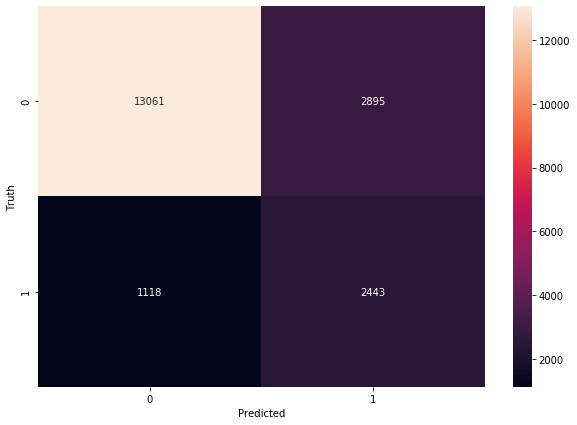

In [60]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [61]:
model.evaluate(X_train, y_train)

2440/2440 [==============================] - 2s 836us/step - loss: 0.3151 - accuracy: 0.8568


[0.3150719106197357, 0.8568024635314941]